# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-CML-example-data" data-toc-modified-id="Load-CML-example-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load CML example data</a></div><div class="lev1 toc-item"><a href="#Do-a-simple-standard-processing-to-get-rain-rates-for-each-CML" data-toc-modified-id="Do-a-simple-standard-processing-to-get-rain-rates-for-each-CML-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Do a simple standard processing to get rain rates for each CML</a></div><div class="lev1 toc-item"><a href="#Do-IDW-interpolation-of-CML-rain-rates" data-toc-modified-id="Do-IDW-interpolation-of-CML-rain-rates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Do IDW interpolation of CML rain rates</a></div><div class="lev2 toc-item"><a href="#Initialize-interpolator" data-toc-modified-id="Initialize-interpolator-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Initialize interpolator</a></div><div class="lev2 toc-item"><a href="#Perform-interpolation-for-all-time-steps" data-toc-modified-id="Perform-interpolation-for-all-time-steps-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Perform interpolation for all time steps</a></div>

In [1]:
%matplotlib inline

In [2]:
import pycomlink as pycml

import matplotlib.pyplot as plt
from tqdm import tqdm

# Load CML example data
Coordinates mimic the real network topology but are fake

In [3]:
cml_list = pycml.io.examples.get_75_cmls()

75 CMLs read in


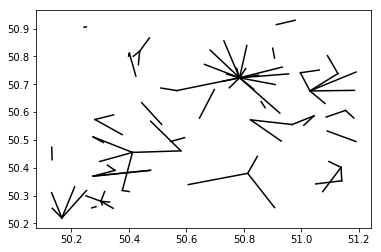

In [4]:
fig, ax = plt.subplots()
for cml in cml_list:
    cml.plot_line(ax=ax, color='k')

# Do a simple standard processing to get rain rates for each CML

In [5]:
for cml in tqdm(cml_list):
    window_length = 60
    threshold = 1.0
    cml.process.wet_dry.std_dev(window_length=window_length, threshold=threshold)
    cml.process.baseline.linear()
    cml.process.baseline.calc_A()
    cml.process.A_R.calc_R()

100%|██████████| 75/75 [00:01<00:00, 43.09it/s]


# Do IDW interpolation of CML rain rates

The `ComlinkGridInterpolator` takes a `PointsToGridInterpolator` object as argument, which is used for the interpolation of each time step. You can pass config arguments to the initialization of the `PointsToGridInterpolator`.

Currently only the IDW interpolator `IdWKdtreeInterpolator` which subclasses `PointsToGridInterpolator` is available. A Kriging version is already implemented but does not work reliably.

## Initialize interpolator 

`resolution` is used to generate a grid using a bounding box aroudn all CMLs if no x- and y-grid are supplied.

Currently CML rain rates are averaged to hourly data before interpolating.

In [6]:
cml_interp = pycml.spatial.interpolator.ComlinkGridInterpolator(
    cml_list=cml_list,
    resolution=0.01,
    interpolator=pycml.spatial.interpolator.IdwKdtreeInterpolator())

## Perform interpolation for all time steps 

In [7]:
ds = cml_interp.loop_over_time()

100%|██████████| 48/48 [00:01<00:00, 47.07it/s]


In [8]:
ds

<xarray.Dataset>
Dimensions:  (time: 48, x: 106, y: 71)
Coordinates:
    lat      (y, x) float64 50.23 50.23 50.23 50.23 50.23 50.23 50.23 50.23 ...
    lon      (y, x) float64 50.12 50.13 50.14 50.15 50.16 50.17 50.18 50.19 ...
  * time     (time) datetime64[ns] 2017-06-28T01:00:00 2017-06-28T02:00:00 ...
Dimensions without coordinates: x, y
Data variables:
    R        (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

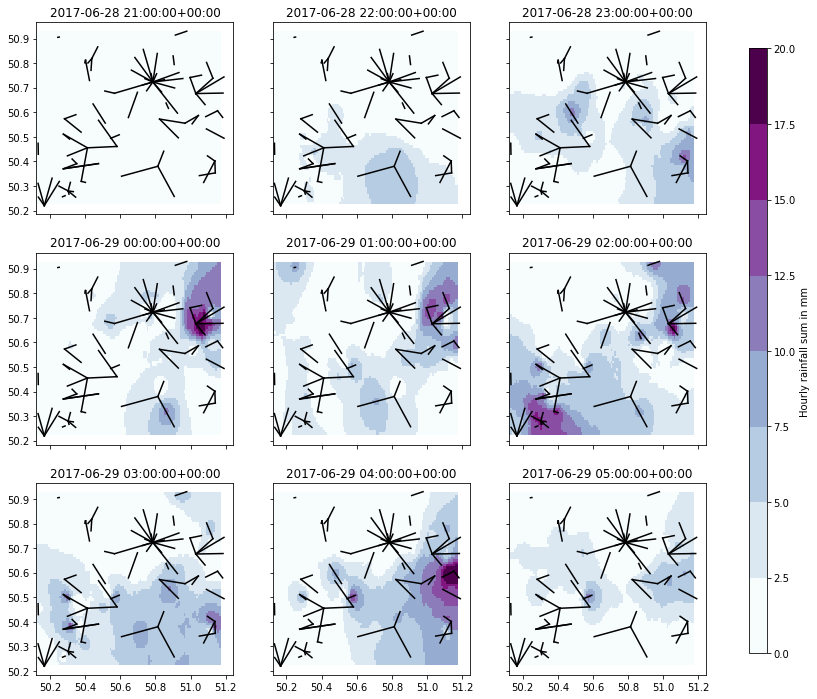

In [9]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))

for i, axi in enumerate(ax.flat):
    for cml in cml_list:
        cml.plot_line(ax=axi, color='k')
    
    pc = axi.pcolormesh(ds.lon,
                        ds.lat,
                        ds.R.isel(time=20+i), 
                        cmap=plt.get_cmap('BuPu', 8), 
                        vmin=0,
                        vmax=20)
    axi.set_title(cml_interp.df_cmls.index[20+i])
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='Hourly rainfall sum in mm');

# Calculate CML coverage mask 

Coverage for 0.05 degree coverage around CMLs.

Note: Calculating coverage using lon-lat and degrees does result in distortions. In the future this will be done using a area preserving reprojection of the lon-lat coordinates before calculating coverage.

Checking intersections: 100%|██████████| 7526/7526 [00:06<00:00, 1112.04it/s]


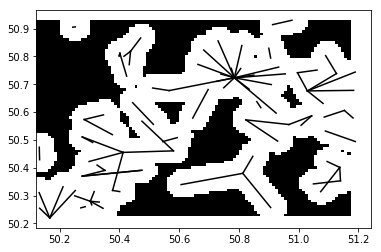

In [10]:
cml_coverage_mask = pycml.spatial.coverage.calc_coverage_mask(
    cml_list=cml_list, 
    xgrid=ds.lon.values,
    ygrid=ds.lat.values,
    max_dist_from_cml=0.05)

fig, ax = plt.subplots()
for cml in cml_list:
        cml.plot_line(ax=ax, color='k')
ax.pcolormesh(ds.lon, ds.lat, cml_coverage_mask, cmap='gray');

Coverage for 0.1 degree coverage around CMLs.

Checking intersections: 100%|██████████| 7526/7526 [00:02<00:00, 2860.53it/s]


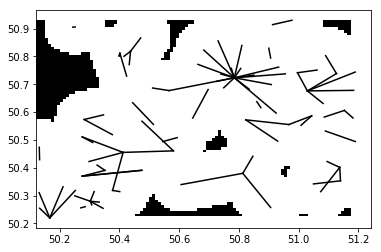

In [11]:
cml_coverage_mask = pycml.spatial.coverage.calc_coverage_mask(
    cml_list=cml_list, 
    xgrid=ds.lon.values,
    ygrid=ds.lat.values,
    max_dist_from_cml=0.1)

fig, ax = plt.subplots()
for cml in cml_list:
        cml.plot_line(ax=ax, color='k')
ax.pcolormesh(ds.lon, ds.lat, cml_coverage_mask, cmap='gray');

# Plot CML rainfall sum and apply coverage map

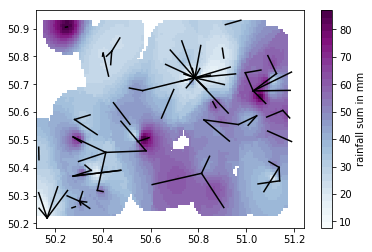

In [12]:
fig, ax = plt.subplots()
for cml in cml_list:
    cml.plot_line(ax=ax, color='k')
pc = ax.pcolormesh(
    ds.lon, 
    ds.lat,
    ds.R.sum(dim='time').where(cml_coverage_mask),
    cmap=plt.get_cmap('BuPu', 32))
plt.colorbar(pc, label='rainfall sum in mm');